## Multi-Class Text Classification Example

Sources:
1. Based on this write-up: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
2. Original source code: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

Goal: Classify text values into discrete categories through the following <br>
1. Prep data for analysis by converting raw documents into tf-idf values
2. Find the most highly correlated features by running chi2 test
3. Break down the process of building a predictive model using Multinomial NB as an example: <br>
a. Split the dataset into training and test data <br>
b. Using TfidfVectorizer, fit() learns the vocabulary of the training data (tokenizes terms in the entire corpus into features). transform() returns the document-term matrix with tf-idf values for every record. These can be called together using fit_transform() <br>
c. Call transform() with testing data to transform new documents into vectors <br>
d. Train the Multinomial NB classifier using fit(); test on new data using predict() <br>
4. Compare different models and select the best performing one based on accuracy

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

## Import the consumer complaints dataset
Download here: https://catalog.data.gov/dataset/consumer-complaint-database

In [7]:
cc = pd.read_csv('Consumer_Complaints.csv')
cc.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
2,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760
3,11/13/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,U.S. BANCORP,MN,48322,NaN,NaN,Phone,11/20/2013,Closed with monetary relief,Yes,No,596562
4,06/16/2015,Debt collection,Medical,Improper contact or sharing of info,Contacted employer after asked not to,NaN,Company believes it acted appropriately as aut...,California Accounts Service,CA,92111,NaN,Consent not provided,Web,06/19/2015,Closed with explanation,Yes,No,1422680


## Basic data cleansing

In [8]:
cc_test = cc.copy()

In [9]:
# for this exercise, keep only data from 2018
START_DATE = pd.to_datetime('2018-01-01')

cc_test['Date received'] = cc_test['Date received'].apply(pd.to_datetime, errors='coerce')
cc_test = cc_test.loc[cc_test['Date received'] >= START_DATE]

In [10]:
# keep only two columns from this dataset
cc_test = cc_test[['Product','Consumer complaint narrative']]
cc_test = cc_test.rename(columns={'Product':'product','Consumer complaint narrative':'complaint'})

In [11]:
cc_test.head()

,product,complaint
85,Credit card or prepaid card,NaN
86,Credit card or prepaid card,NaN
87,Vehicle loan or lease,This company calls me multiple times a day if ...
88,Mortgage,I applied for Hardship around the begining of ...
127,Checking or savings account,NaN


In [12]:
# drop rows with null complaints
cc_test = cc_test[pd.notnull(cc_test['complaint'])]

In [13]:
# sklearn.preprocessing functions used in this notebook:
# LabelEncoder represents categorical variables as integers instead of strings; same result as pandas factorize
# inverse_transform to map back

le = LabelEncoder()
cc_test['category_id'] = le.fit_transform(cc_test['product'])
cc_test.head()

,product,complaint,category_id
87,Vehicle loan or lease,This company calls me multiple times a day if ...,8
88,Mortgage,I applied for Hardship around the begining of ...,5
224,Debt collection,XXXX XXXX policy was switched after an the quo...,3
226,"Payday loan, title loan, or personal loan",Around the first week of XX/XX/XXXX I initiate...,6
654,Debt collection,I filed a compliant against this company X/X/2...,3


In [14]:
category_mapping = cc_test[['product','category_id']].drop_duplicates().sort_values('category_id')
category_mapping

,product,category_id
3000,Checking or savings account,0
1797,Credit card or prepaid card,1
787,"Credit reporting, credit repair services, or o...",2
224,Debt collection,3
1151,"Money transfer, virtual currency, or money ser...",4
88,Mortgage,5
226,"Payday loan, title loan, or personal loan",6
4092,Student loan,7
87,Vehicle loan or lease,8


## Data snapshot

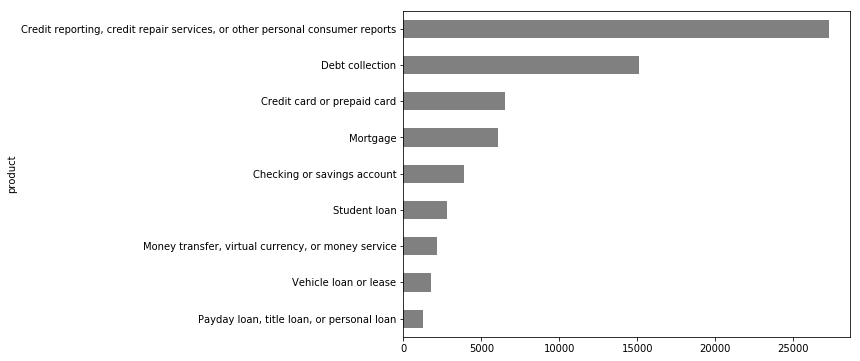

In [15]:
# visualize case count per product category
cat_count = cc_test.groupby(cc_test['product']).category_id.count().sort_values(ascending=True)

fig = plt.figure(figsize=(8,6))
cat_count.plot.barh(color='grey')
plt.show()

## Use tf-idf to transform text into tf-idf values

Resources:
1. https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html
2. On how tf-idf works and impact of L1/L2 norms: http://jonathansoma.com/lede/foundations/classes/text%20processing/tf-idf/

In [16]:
# TfidfVectorizer transforms a collection of raw documents to a matrix of tf-idf features
# Equivalent to CountVectorizer followed by TfidfTransformer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(cc_test.complaint)

In [17]:
features

<66832x166893 sparse matrix of type '<class 'numpy.float64'>'
	with 7146950 stored elements in Compressed Sparse Row format>

In [18]:
# example of what the matrix looks like as a dataframe
# feature indices are replaced with feature names, which are both unigrams and bigrams
pd.DataFrame(features.toarray(), columns=tfidf.get_feature_names()).head()

,00,00 00,00 000,00 10,00 100,00 1000,00 10000,00 100000,00 11,00 110,...,zip file,zip xxxx,zombie,zombie debt,zone,zone hurricane,zone xxxx,zoned,zwicker,zwicker associates
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.044207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Find features most highly correlated with each label

In [20]:
# N refers to the number of features we want to return
N = 2

# these are used to split features by category
labels = cc_test.category_id
category_mapping_dict = dict(category_mapping.values)
category_mapping_dict

{'Checking or savings account': 0,
 'Credit card or prepaid card': 1,
 'Credit reporting, credit repair services, or other personal consumer reports': 2,
 'Debt collection': 3,
 'Money transfer, virtual currency, or money service': 4,
 'Mortgage': 5,
 'Payday loan, title loan, or personal loan': 6,
 'Student loan': 7,
 'Vehicle loan or lease': 8}

In [21]:
# https://github.com/scikit-learn/scikit-learn/blob/a24c8b464d094d2c468a16ea9f8bf8d42d949f84/sklearn/feature_selection/univariate_selection.py#L171
# the chi2 function returns two values (chi2 statistics of each feature and p-values of each feature)
chi2_test = chi2(features,labels)
chi2_test

(array([187.67328333,  10.14845366,   1.11764538, ...,   0.35928841,
          5.05411026,   3.59020084]),
 array([2.51297072e-36, 2.54760682e-01, 9.97390262e-01, ...,
        9.99962398e-01, 7.51777409e-01, 8.92077536e-01]))

In [22]:
for product, category_id in sorted(category_mapping_dict.items()):
  # calculate chi2 for every feature, iterating through each label
  features_chi2 = chi2(features, labels == category_id)
    
  # argsort() returns the indices that would sort an array in ascending order
  # sort the first value which is the chi2 statistic
  indices = np.argsort(features_chi2[0])

  # map feature indices to feature names
  feature_names = np.array(tfidf.get_feature_names())[indices]

  # categorize feature names as unigrams/bigrams
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

  print("\nCategory: '{}'".format(product))
  print("Unigrams: '{}'".format(unigrams[-N:]))
  print("Bigrams: '{}'".format(bigrams[-N:]))


Category: 'Checking or savings account'
Unigrams: '['deposit', 'overdraft']'
Bigrams: '['overdraft fees', 'checking account']'

Category: 'Credit card or prepaid card'
Unigrams: '['citi', 'card']'
Bigrams: '['american express', 'credit card']'

Category: 'Credit reporting, credit repair services, or other personal consumer reports'
Unigrams: '['report', 'inquiries']'
Bigrams: '['appear report', 'credit report']'

Category: 'Debt collection'
Unigrams: '['collection', 'debt']'
Bigrams: '['cease desist', '15 usc']'

Category: 'Money transfer, virtual currency, or money service'
Unigrams: '['wire', 'coinbase']'
Bigrams: '['xxxx coinbase', 'coinbase account']'

Category: 'Mortgage'
Unigrams: '['modification', 'mortgage']'
Bigrams: '['escrow account', 'loan modification']'

Category: 'Payday loan, title loan, or personal loan'
Unigrams: '['loan', 'payday']'
Bigrams: '['picture loans', 'big picture']'

Category: 'Student loan'
Unigrams: '['loans', 'navient']'
Bigrams: '['student loan', 'loan

## Use this dataset to train classifiers and predict products

Resources:
1. Random Forest: https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

### Example with Multinomial NB

In [76]:
X_train, X_test, y_train, y_test = train_test_split(cc_test['complaint'], cc_test['product'], random_state=42)

In [78]:
# initiate the vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)

# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# Multinomial NB Classifier is most suitable for word counts; could work for fractional counts such as tf-idf values
# Training data x is expected to be matrix-like with the shape [n_samples,n_features]
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [90]:
X_train_tfidf.shape

(50124, 127492)

In [99]:
test = tfidf.transform(["Zwicker has repeatedly tried to contact me"])
pd.DataFrame(test.toarray(),columns=tfidf.get_feature_names())

,00,00 00,00 10,00 100,00 1000,00 10000,00 11,00 110,00 1100,00 11000,...,zip,zip code,zip codes,zip file,zombie,zombie debt,zone,zone hurricane,zwicker,zwicker associates
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625331,0.0


In [79]:
# tfidf.transform() converts text into document-term matrix, with tf-idf values
# predict() performs classification on the test vector
print(clf.predict(tfidf.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [80]:
print(clf.predict(tfidf.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


### Benchmark different models and compare accuracy

In [81]:
models = [RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
          LogisticRegression(random_state=0), LinearSVC(), MultinomialNB()]

In [82]:
# http://scikit-learn.org/stable/modules/cross_validation.html
# CV specifies the number of folds; the model is trained k times, each time using k-1 of the folds as training data
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  # all scoring values here: http://scikit-learn.org/stable/modules/model_evaluation.html
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [84]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.407928
1,RandomForestClassifier,1,0.407989
2,RandomForestClassifier,2,0.408020
3,RandomForestClassifier,3,0.408037
4,RandomForestClassifier,4,0.408067
5,LogisticRegression,0,0.832162
6,LogisticRegression,1,0.836026
7,LogisticRegression,2,0.832573
8,LogisticRegression,3,0.839419
9,LogisticRegression,4,0.834393


In [86]:
cv_df.groupby(cv_df['model_name']).accuracy.mean()

model_name
LinearSVC                 0.852975
LogisticRegression        0.834915
MultinomialNB             0.688682
RandomForestClassifier    0.408008
Name: accuracy, dtype: float64

## Next: continue with best-performing model (LinearSVC)